# WaPOR v2 API Tutorial




> ⚠️ For an example on how to download WaPOR v3 data, go [here](https://colab.research.google.com/github/un-fao/FAO-Water-Applications/blob/main/WaPOR/WaPORv3_API.ipynb).

In this notebook we'll have a look at how to download WaPOR  v2 data using the [GISMGR 1.0 API](https://io.apps.fao.org/gismgr/api/v1/swagger-ui.html) for a specific region. You'll need a WaPOR-API-token to run this notebook, which you can get [here](https://wapor.apps.fao.org/home/) (go to your profile page after registering to get a token). Let's get started by importing the modules we are going to use.

In [1]:
import requests
from osgeo import gdal
import matplotlib.pyplot as plt
import getpass

The most important module here is `requests`, we'll use this module to communicate with the WaPOR server. `gdal` is used download a subset of the data to our local machine. `matplotlib` is used to have a look at the downloaded data. Finally, `getpass` is simply used to savely work with your API token.

## Requesting a WaPOR tif-file (Part 1)

Requesting a specific tif-file from the WaPOR server is done by specifying a URL and sending this URL to the server. There are three important variables in this URL, i.e. `workspace`, `cubecode` and `rasterid`.

`workspace` defines which dataset we want to access, we'll leave that set to `WAPOR_2` for the rest of this workbook. `cubecode` defines which variable we are interested in, I'm setting it to `L1_AETI_A` for now, which stands for something like "Level 1 Actual Evapotranspiration Annual". Lastly, `rasterid` in this case allows us to specify for which year we are requesting data (2016 in this example).

In [2]:
workspace = "WAPOR_2"
cubecode = "L1_AETI_A"
rasterid = "L1_AETI_16"

tif_request_url = f"https://io.apps.fao.org/gismgr/api/v1/download/{workspace}?requestType=MAPSET_RASTER&cubeCode={cubecode}&rasterId={rasterid}"

Using the `requests` module, we can send this request to the WaPOR server.

In [3]:
tif_request_response = requests.get(tif_request_url)

And we can check if the request was succesfull or not (⚠️ spoiler: it's not succesfull ⚠️).

In [4]:
tif_request_response.raise_for_status()

HTTPError: 401 Client Error: Unauthorized for url: https://io.apps.fao.org/gismgr/api/v1/download/WAPOR_2?requestType=MAPSET_RASTER&cubeCode=L1_AETI_A&rasterId=L1_AETI_16

We can't just request data like that, we need to include some authorization in that request. Let's prepare the authorization in the next part, before we come back to this request.

## Authorization

We are first going to send our API token to the server, let's start by storing the token in a variable.

In [ ]:
api_token = getpass.getpass("WaPOR API Token:")

WaPOR API Token:··········


Ok, now that we have a variable called `api_token`, we can communicate it to the server.

In [ ]:
authorization_request_url = "https://io.apps.fao.org/gismgr/api/v1/iam/sign-in"
authorization_headers = {"X-GISMGR-API-KEY": api_token}
authorization_request_response = requests.post(authorization_request_url, headers = authorization_headers)
authorization_request_response.raise_for_status()

And check what is in the response like this.

In [ ]:
authorization_request_response.json()

{'requestId': '01cc0fd9-85f5-428e-b9ea-901d13a6db44',
 'timestamp': 1678199155249,
 'runtime': 818,
 'status': 200,
 'message': 'OK',
 'response': {'accessToken': 'eyJhbGciOiJSUzI1NiIsImtpZCI6ImY4NzZiNzIxNDAwYmZhZmEyOWQ0MTFmZTYwODE2YmRhZWMyM2IzODIiLCJ0eXAiOiJKV1QifQ.eyJuYW1lIjoiQmVydCBDb2VydmVyIiwiaXNzIjoiaHR0cHM6Ly9zZWN1cmV0b2tlbi5nb29nbGUuY29tL3VuZmFvLWFwcHMtZGV2IiwiYXVkIjoidW5mYW8tYXBwcy1kZXYiLCJhdXRoX3RpbWUiOjE2NzgxOTkxNTUsInVzZXJfaWQiOiJDTFpxaE5IVWdwY05pY3ZJeXpWMjJHSGloZk4yIiwic3ViIjoiQ0xacWhOSFVncGNOaWN2SXl6VjIyR0hpaGZOMiIsImlhdCI6MTY3ODE5OTE1NSwiZXhwIjoxNjc4MjAyNzU1LCJlbWFpbCI6ImIuY29lcnZlckBtYWlsYm94Lm9yZyIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJmaXJlYmFzZSI6eyJpZGVudGl0aWVzIjp7ImVtYWlsIjpbImIuY29lcnZlckBtYWlsYm94Lm9yZyJdfSwic2lnbl9pbl9wcm92aWRlciI6ImN1c3RvbSJ9fQ.S5CxKNzSNOaOnuxdvd5D4Tv5DkLf4vcHKt3OQzB-w6UhtYyKcYatXP3LOhSKYBaC0KA3i7Uk92jmtUO2oUrxny8Kmdznic1Ds14UbkajJKLfYBdZGt3fZ6fCVF_O84d3zhuUgNCgZHwrYRc-Hshky81m1yOrcQG7e7uKsjcrtGpnHwg3v3rn7hfKs9w5GiM5ZHdMt4lkYYBAG9bFV2T0yFtV1KZE29VIWm

There are a couple of important things here. First, we see a `status` of 200, that's good (basically anything between 200 and 299 is good, see [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status) for more info). Then we see a `accessToken`, this is another (temporary) token which we can include with our request for data (the one that failed before). So lets save that `accessToken` to a variable.

In [ ]:
access_token = authorization_request_response.json()["response"]["accessToken"]

## Requesting a WaPOR tif-file (Part 2)

Now that we have this access token, we can include it with our previous failed request.

In [ ]:
tif_headers = {"Authorization": f"Bearer {access_token}"}
tif_request_response = requests.get(tif_request_url, headers = tif_headers)
tif_request_response.raise_for_status()

No error this time! 🎉

Let's have a look at the response.

In [ ]:
tif_request_response.json()

{'requestId': 'fbd01cfc-0c52-471b-80de-a0da817cef6b',
 'timestamp': 1678199161302,
 'runtime': 35,
 'status': 200,
 'message': 'OK',
 'response': {'expiresIn': 3600,
  'downloadUrl': 'https://io.apps.fao.org/gismgr/download/cb77f4f0-4958-4a10-b10b-3aceb3cee3d4/L1_AETI_16.tif'}}

Status is good (again), and now we see a new URL under `downloadUrl`. This is a direct link to the tif file we are interested in. You could stop reading the rest of this notebook and just past this URL in your browser and get the file.

However, this file is quite large (about 1.5GB) and perhaps you are only interested in a small part of it. Luckily for us, its not just any tif-file, but a [Cloud Optimized Geotiff](https://www.cogeo.org). In the next section, we'll see how we can download a small subset of this file using `gdal`. For now lets store the URL in a new variable.

In [ ]:
tif_url = tif_request_response.json()["response"]["downloadUrl"]

## Downloading a subset of a COG

Using the Python implementation of [gdal_translate](https://gdal.org/programs/gdal_translate.html) we can download a part of the file (the command line version would work as well ofcourse). We start by specifying a bounding-box, which bands (this particular file has only 1 band so it's an easy choice) of the Geotiff we want to have and where we want to store the downloaded file.

In [ ]:
bounding_box = [30.0, 30.5, 31.5, 28.5] # left, top, right, bottom
bands = [1]
output_filepath = r"example_subset.tif"

Then we pass these variables to `gdal.TranslateOptions` (you can check out what other options are available by running `help(gdal.TranslateOptions)`, e.g. you can also create a netCDF file instead of a GeoTIFF or add a download progress bar).

In [ ]:
translate_options = gdal.TranslateOptions(projWin=bounding_box, bandList=bands)

Next we can run `gdal.Translate`.

> ⚠️ You'll see that we have to add a small string (`"/vsicurl/"`) in front of the URL we've found earlier, this is to tell `gdal` that we are not dealing with a normal local file, but with a file somewhere on a server (see [here](https://gdal.org/user/virtual_file_systems.html#gdal-virtual-file-systems-compressed-network-hosted-etc-vsimem-vsizip-vsitar-vsicurl) for more info).




In [ ]:
ds = gdal.Translate(output_filepath, f"/vsicurl/{tif_url}", options = translate_options)

That should finish in a couple of seconds, finally we can quickly create a simple plot to see if the data was really downloaded.

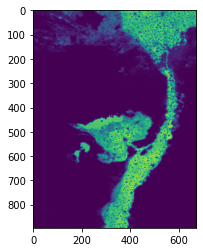

In [ ]:
array = ds.GetRasterBand(1).ReadAsArray()
plt.imshow(array)

Until now we have used only one specific `cubecode` and `rasterid`. Below I'll show how you can figure out what other valid values for them exist.

## Cubecodes

We can send a request to the WaPOR server asking it to tell us more about the valid values for `cubecode` like this.

In [ ]:
cubes_request_url = f"https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/cubes?paged=false"
cubes_request_response = requests.get(cubes_request_url)
cubes_request_response.raise_for_status()

And inspect the response like this.

In [ ]:
{x["code"]: x["caption"] for x in cubes_request_response.json()["response"]}

{'L1_GBWP_A': 'Gross Biomass Water Productivity',
 'L1_NBWP_A': 'Net Biomass Water Productivity',
 'L1_AETI_A': 'Actual EvapoTranspiration and Interception (Annual)',
 'L1_AETI_M': 'Actual EvapoTranspiration and Interception (Monthly)',
 'L1_AETI_D': 'Actual EvapoTranspiration and Interception (Dekadal)',
 'L1_T_A': 'Transpiration (Annual)',
 'L1_E_A': 'Evaporation (Annual)',
 'L1_I_A': 'Interception (Annual)',
 'L1_T_D': 'Transpiration (Dekadal)',
 'L1_E_D': 'Evaporation (Dekadal)',
 'L1_I_D': 'Interception (Dekadal)',
 'L1_NPP_D': 'Net Primary Production (Dekadal)',
 'L1_NPP_M': 'Net Primary Production (Monthly)',
 'L1_TBP_A': 'Total Biomass Production (Annual)',
 'L1_LCC_A': 'Land Cover Classification',
 'L1_RET_A': 'Reference EvapoTranspiration (Annual)',
 'L1_PCP_A': 'Precipitation (Annual)',
 'L1_RET_M': 'Reference EvapoTranspiration (Monthly)',
 'L1_PCP_M': 'Precipitation (Monthly)',
 'L1_RET_D': 'Reference EvapoTranspiration (Dekadal)',
 'L1_PCP_D': 'Precipitation (Dekadal)',
 

## RasterIDs

For a specific `cubecode`, we can ask which valid values for `rasterid` exist like this.

In [ ]:
cubecode = 'L1_NPP_D'
page = 1
rasterid_request_url = f"https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/cubes/{cubecode}/rasters?page={page}"
rasterid_request_response = requests.get(rasterid_request_url)
rasterid_request_response.raise_for_status()

And inspect the response.

In [ ]:
{x["rasterId"]: (x["DEKAD"]["caption"]) for x in rasterid_request_response.json()["response"]["items"]}

{'L1_NPP_0921': '2009-07 from 21 to 31',
 'L1_NPP_0922': '2009-08 from 01 to 10',
 'L1_NPP_0923': '2009-08 from 11 to 20',
 'L1_NPP_0924': '2009-08 from 21 to 31',
 'L1_NPP_0925': '2009-09 from 01 to 10',
 'L1_NPP_0926': '2009-09 from 11 to 20',
 'L1_NPP_0927': '2009-09 from 21 to 30',
 'L1_NPP_0928': '2009-10 from 01 to 10',
 'L1_NPP_0929': '2009-10 from 11 to 20',
 'L1_NPP_0930': '2009-10 from 21 to 31',
 'L1_NPP_0931': '2009-11 from 01 to 10',
 'L1_NPP_0932': '2009-11 from 11 to 20',
 'L1_NPP_0933': '2009-11 from 21 to 30',
 'L1_NPP_0934': '2009-12 from 01 to 10',
 'L1_NPP_0935': '2009-12 from 11 to 20',
 'L1_NPP_0936': '2009-12 from 21 to 31',
 'L1_NPP_1001': '2010-01 from 01 to 10',
 'L1_NPP_1002': '2010-01 from 11 to 20',
 'L1_NPP_1003': '2010-01 from 21 to 31',
 'L1_NPP_1004': '2010-02 from 01 to 10'}

By increasing the `page` variable, `rasterID`s for other dates can be found.